In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:

headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df = pd.read_csv ('sani_clean.csv', names=headers)#, index_col='Timestamp', parse_dates = True)
df=df[1:]

In [3]:
flow = df[['AV Flow (L/s)']]
dataset=flow.values


In [4]:
dataset = dataset.astype('float32')

In [25]:
# flow['Timestamp'] = pd.to_datetime(flow['Timestamp'])

# flow = flow.set_index('Timestamp')

In [5]:
# flow['AV Flow (L/s)'] = flow['AV Flow (L/s)'].astype(float)

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [6]:
flow

,AV Flow (L/s)
1,0.4
2,0.24
3,0.15
4,0.17
5,0.23
...,...
994,0.66
995,0.57
996,0.42
997,0.52


In [48]:
numpy.random.seed(7)

In [49]:
sc = MinMaxScaler(feature_range = (0, 1))
dataset = sc.fit_transform(dataset)

In [50]:
# split into train and test sets
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [68]:

# print(len(train), len(test))
print(len(train), len(test))
# setup look_back window 
look_back = 1
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

668 330


In [71]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [72]:
trainX.shape

(667, 1, 1)

In [73]:
#2,4,8,16,32,64,128,256,512,1024
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

model=Sequential()
model.add(Dense(units=64, input_dim=look_back, activation='relu'))
model.add(Dense(units=32, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
model.fit(trainX,trainY, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.0999
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0816
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0742
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0748
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0721
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0710
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0713
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0704
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0721
Epoch 10/100
21/21 [========

In [74]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([trainY])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.16 RMSE
Test Score: 0.19 RMSE


In [75]:
testPredictPlot.shape

(998, 1)

In [56]:
trainPredict.shape

(667, 1)

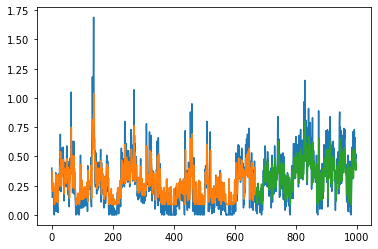

In [76]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(sc.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()